In [78]:
import numpy as np  
import matplotlib.pyplot as plt
import torch

In [79]:
n_train = 500
torch.manual_seed(42)
# Create a random dataset [-1, 1] x [-1, 1]
X_train = torch.rand(n_train, 1) * 2 - 1
# X_train = torch.randn(n_train, 1)

# Sort the data
X_train, _ = torch.sort(X_train, dim=0)
X_train[:5]

tensor([[-0.9953],
        [-0.9948],
        [-0.9942],
        [-0.9927],
        [-0.9919]])

In [80]:
from sklearn.preprocessing import PolynomialFeatures

# Create a polynomial feature transformer
poly = PolynomialFeatures(degree=25)

# Create polynomial features
X = poly.fit_transform(X_train)
X = torch.tensor(X, dtype=torch.float32)
print(X.shape)
# X[:,0] - 1
# X[:,1] - X_train[:,0]
# X[:,2] - X_train[:,0]**2

torch.Size([500, 26])


In [81]:
# standardize the data
X = (X - X.mean(dim=0)) / X.std(dim=0)
X[:,0] = 1
# (X[:,2] - X.mean(dim=0)[2]) - (X - X.mean(dim=0))[:,2]

tensor([ 1., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

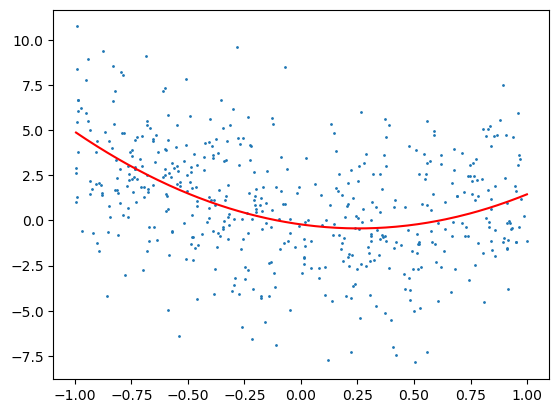

In [82]:
theta_tru = torch.tensor([1, -1, 1], dtype=torch.float32)*1
theta_tru = torch.cat([theta_tru, torch.zeros(X.shape[1] - theta_tru.shape[0])])
# theta_tru = torch.tensor([-0.4527545, 0.1877339, -0.6796304, 0, 0, 0], dtype=torch.float32)

# torch.manual_seed(1337)
# theta_tru = 5*torch.randn(3)
# pad theta_tru with zeros


# theta_tru = torch.randn(X.shape[1])
sig = 3
f_tru = X @ theta_tru
y_train = f_tru + torch.randn(n_train) * sig

# Plot the data
plt.scatter(X_train, y_train, s=1)
plt.plot(X_train, f_tru, color='red')
theta_tru

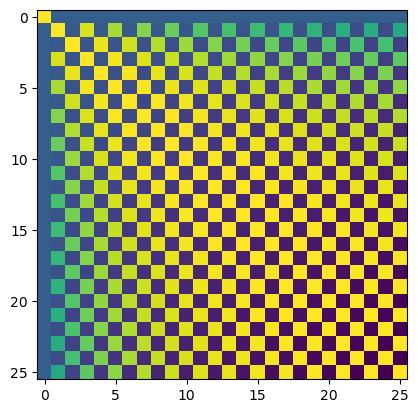

In [83]:
Cxx = X.T @ X / n_train # Covariance of X
Cxy = X.T @ y_train / n_train # Cross covariance of X and y

# plot Cxx
plt.imshow(Cxx)

tensor([   0.9660,    4.8167,   16.9558,  -80.0213, -110.2060,  350.5629,
         195.0777, -657.0805,   72.6718,  549.2933, -311.2145, -183.4158,
           5.4953,   10.0501, -113.1437,   16.1387,  420.9857,   80.4489,
          77.8398,  -58.2191, -291.8565,  -81.8674,   -8.8559,  -24.9232,
          47.0667,   73.3572])


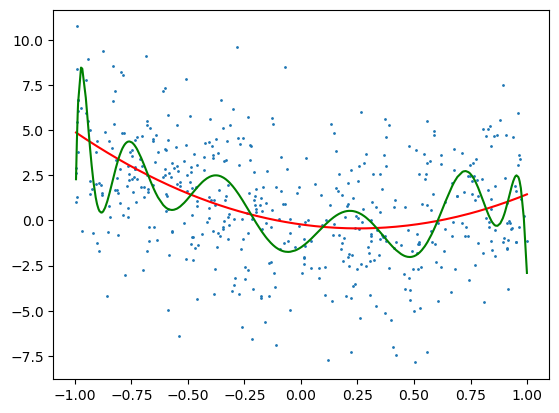

In [84]:
# Ridge regression
# theta_ridge = torch.solve(Cxy[:,None], C + regparam * torch.eye(C.shape[0]))[0].squeeze()

def solve_ridge(Cxx, Cxy, regparam):
    return torch.linalg.solve(Cxx + regparam * torch.eye(Cxx.shape[0]), Cxy[:,None]).squeeze()

theta_ridge = solve_ridge(Cxx, Cxy, regparam = 0)
print(theta_ridge)

# plot the ridge regression solution
f_ridge = X @ theta_ridge
plt.scatter(X_train, y_train, s=1)
plt.plot(X_train, f_tru, color='red')
plt.plot(X_train, f_ridge, color='green')


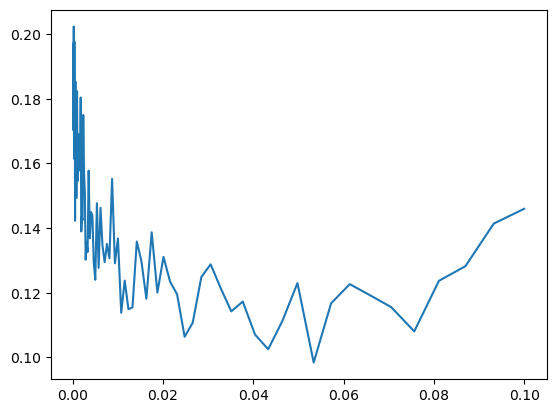

In [85]:
from itertools import product
import pandas as pd

n_reps = 50
n_regparams = 100
regparams = np.logspace(-4, -1, n_regparams)
res = []
for rep, regparam in product(range(n_reps), regparams):
    y_train = f_tru + torch.randn(n_train) * sig
    
    Cxy = X.T @ y_train / n_train
    theta_ridge = solve_ridge(Cxx, Cxy, regparam)
    f_ridge = X @ theta_ridge
    # loss = torch.mean((f_ridge - y_train)**2).item()
    loss = torch.mean((f_tru - f_ridge)**2).item()
    # store rep, regparam, loss
    res.append({'rep':rep, 'regparam':regparam, 'loss':loss})

res = pd.DataFrame(res)

# average over repetitions
res = res.groupby('regparam').mean().reset_index()

# plot the results
plt.plot(res.regparam, res.loss)
#plt.xscale('log')

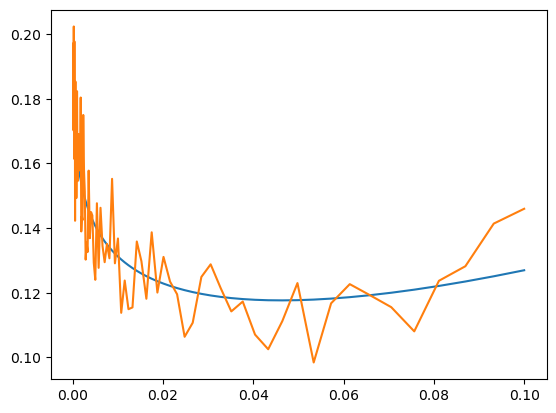

In [86]:
# svd of X
U, S, V = torch.linalg.svd(X / np.sqrt(n_train), full_matrices=False)
U.shape, S.shape, V.shape
# S, torch.linalg.eigvalsh(X.T @ X)

xi_tru = U.T @ f_tru / np.sqrt(n_train)
mu = S**2


def get_theor_mse(regparam):
    Gamma = torch.diag(mu / (mu + regparam))
    z = (torch.eye(Gamma.shape[0]) - Gamma) @ xi_tru
    bias = (z**2).sum()
    variance = (sig**2 / n_train) * torch.trace(Gamma**2)
    return bias + variance

# theor_mses = torch.zeros_like(regparams)
plt.plot(regparams, [get_theor_mse(regparam) for regparam in regparams])
plt.plot(res.regparam, res.loss)
#plt.xscale('log')
# plot S
# plt.plot(S)

In [87]:
Xn = X.numpy()
# svd of Xn
Un, Sn, Vn = np.linalg.svd(Xn, full_matrices=False)
Un.shape, Sn.shape, Vn.shape
# eigenvlues of Xn.T @ Xn
np.linalg.eigvalsh(Xn.T @ Xn), Sn**2

(array([-1.0843266e-02, -7.3193186e-03, -5.5483095e-03, -2.6671945e-03,
        -1.9165270e-03, -1.5516450e-03, -3.5564485e-04,  1.0879086e-04,
         4.9739471e-04,  1.4674520e-03,  4.1179634e-03,  5.1387884e-03,
         7.7195331e-03,  1.1401676e-02,  4.1302305e-02,  1.7175111e-01,
         6.8389428e-01,  3.1507208e+00,  9.2689438e+00,  4.0655499e+01,
         8.5674164e+01,  4.1994815e+02,  5.0000000e+02,  6.3269116e+02,
         4.1868340e+03,  7.0958750e+03], dtype=float32),
 array([7.0958735e+03, 4.1868330e+03, 6.3269104e+02, 5.0000000e+02,
        4.1994678e+02, 8.5674179e+01, 4.0654480e+01, 9.2684479e+00,
        3.1515095e+00, 6.8335754e-01, 1.7396469e-01, 3.9166555e-02,
        8.4219351e-03, 1.6725038e-03, 2.9621413e-04, 5.9415419e-05,
        7.7672948e-06, 1.3968844e-06, 1.5004865e-07, 2.5937375e-08,
        2.0390425e-09, 3.6503864e-10, 1.8681069e-11, 3.3386360e-12,
        6.3949209e-13, 4.4873057e-13], dtype=float32))

In [88]:
# covariance matrix of X
C = X.T @ X / n_train

# eigenvalues and eigenvectors of C
eigvals, eigvecs = torch.linalg.eigh(C)

eigvecs.shape

# svd of X
U, S, V = torch.linalg.svd(X / np.sqrt(n_train), full_matrices=False)
U.shape, S.shape, V.shape

# verify that V is the same as the eigenvectors of C
V.T @ torch.diag(S**2) @ V, C

# sort eigvales
idx = torch.argsort(eigvals, descending=True)
eigvals = eigvals[idx]
eigvecs = eigvecs[:,idx]

S**2, eigvals

(tensor([1.4192e+01, 8.3737e+00, 1.2654e+00, 1.0000e+00, 8.3989e-01, 1.7135e-01,
         8.1309e-02, 1.8537e-02, 6.3030e-03, 1.3667e-03, 3.4793e-04, 7.8331e-05,
         1.6844e-05, 3.3448e-06, 5.9241e-07, 1.1882e-07, 1.5527e-08, 2.7962e-09,
         2.9983e-10, 5.1995e-11, 4.1417e-12, 1.0319e-12, 2.4124e-13, 4.6849e-14,
         3.6354e-14, 3.2907e-14]),
 tensor([ 1.4192e+01,  8.3737e+00,  1.2654e+00,  1.0000e+00,  8.3990e-01,
          1.7135e-01,  8.1310e-02,  1.8538e-02,  6.3013e-03,  1.3676e-03,
          3.4331e-04,  8.2206e-05,  2.2737e-05,  1.4132e-05,  1.0609e-05,
          8.3149e-06,  1.7151e-06,  1.5164e-07, -5.8832e-07, -1.5596e-06,
         -2.4783e-06, -3.4186e-06, -5.1559e-06, -1.2124e-05, -1.4958e-05,
         -1.7116e-05]))

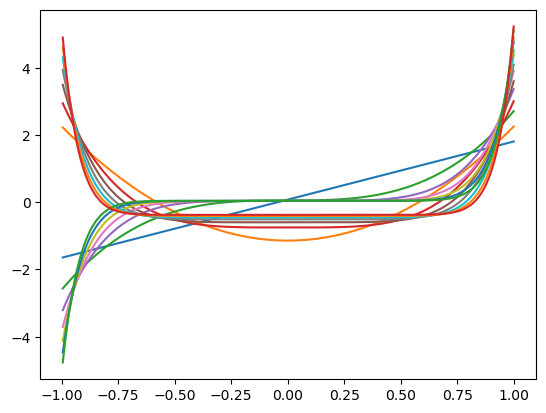

In [89]:
# plot polynomial features X in a loop
for i in range(1, 15):
    plt.plot(X_train, X[:,i], label=f'X**{i}')


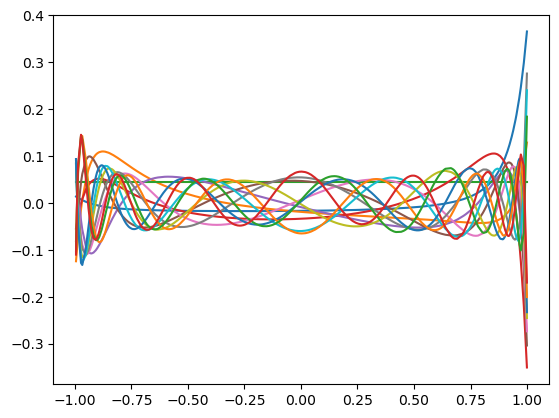

In [90]:
# plot the eigenfunctions
for i in range(1, 15):
    plt.plot(X_train, U[:,i], label=f'X**{i}')